In [3]:
import re

from transformers import AutoTokenizer
import datasets

In [4]:
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
ds = datasets.load_dataset("hkust-nlp/SimpleRL-Zoo-Data", 
                      data_files="simplelr_qwen_level1to4/train.parquet",
                      split="train")

In [5]:
def extract_user_content(content):
    pattern = r'<\|im_start\|>user\n(.*?)<\|im_end\|>'
    match = re.search(pattern, content, re.DOTALL)
    
    if match:
        return match.group(1).strip()
    return None

def map_func(example):
    content = extract_user_content(example["prompt"][0]["content"])
    example["prompt"][0]["content"] = content
    return example

ds_up = ds.map(map_func, num_proc=16)
ds_up = ds_up.select_columns(["prompt", "gt_answer"]).rename_column("gt_answer", "ground_truth")

In [6]:
ds_up[0]

{'prompt': [{'content': 'Find the remainder when $$33818^2 + 33819^2 + 33820^2 + 33821^2 + 33822^2$$is divided by 17.\nPlease reason step by step, and put your final answer within \\boxed{{}}.',
   'role': 'user'}],
 'ground_truth': '0'}

In [7]:
# ds_up.push_to_hub("rasdani/simplerl_qwen_level1to4")

In [9]:
# count tokens in content
def count_tokens(example):
    example["token_count"] = len(tokenizer.encode(example["prompt"][0]["content"]))
    return example

ds_up = ds_up.map(count_tokens, num_proc=16)


Map (num_proc=16): 100%|██████████| 8139/8139 [00:00<00:00, 32270.16 examples/s]


In [10]:
df = ds_up.to_pandas()
df["token_count"].describe()

count    8139.000000
mean       80.058607
std        75.046709
min        24.000000
25%        46.000000
50%        59.000000
75%        82.000000
max      1061.000000
Name: token_count, dtype: float64

<Axes: >

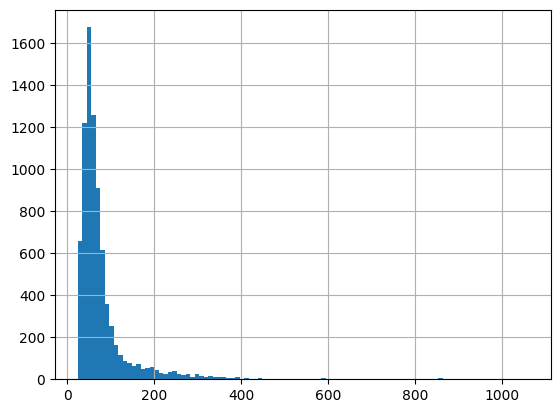

In [11]:
df["token_count"].hist(bins=100)